<a href="https://colab.research.google.com/github/aldrich1221/recommendation-system/blob/main/NFMwithSideInfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import torch
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


In [7]:
class FM(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):     
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix

class MLPlayers(torch.nn.Module):

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

class NeuralFMModel(torch.nn.Module):
    def __init__(self, input_dim,field_dims, embed_dim, mlp_dims, dropouts):
        super().__init__()

        ##feature Embedding
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)
        
        ## first order linear
        output_dim=1
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        
        
        self.fm = torch.nn.Sequential(
            FM(reduce_sum=False),
            torch.nn.BatchNorm1d(embed_dim),
            torch.nn.Dropout(dropouts[0])
        )
        self.embed_dim=embed_dim
        self.mlp = MLPlayers(embed_dim, mlp_dims, dropouts[1])
        
        # self.embedding_matrix = torch.rand(field_dims, self.embed_dim)
        self.lin1=torch.nn.Linear(input_dim, 256,bias=True)
        self.lin2=torch.nn.Linear(256, 1,bias=True)
        
      
    def forward(self, x):
        conPartx=x[0]
        catPartX=x[1]
    
        
        embed=self.embedding(catPartX)
        
        cross_term = self.fm(embed)
        
        conPartx=self.lin1(conPartx)
        conPartx=F.relu(conPartx)
        out1=self.lin2(conPartx)
       
        ## first order linear
        out2 = catPartX + catPartX.new_tensor(self.offsets).unsqueeze(0)
        out2=torch.sum(self.fc(out2), dim=1) + self.bias


        out3=self.mlp(cross_term)
        
        out = out1+out2 + out3
        

        return out.squeeze(1)

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'review_id', 'user_id',
       'business_id', 'stars', 'cool', 'funny', 'useful', 'date', 'text'],
      dtype='object')
EachFeature MAx user_id_code 6
EachFeature MAx business_id_code 133
6 len(dataset)
[6, 133]
epoch: 0 train performance 15.327707569589059 validation: performance: 14.890041981335912
epoch: 1 train performance 12.96392912524066 validation: performance: 12.499245714976169
epoch: 2 train performance 11.394140961033846 validation: performance: 10.778776709885747
epoch: 3 train performance 10.388919234107577 validation: performance: 9.585615879021839
epoch: 4 train performance 9.808833389576158 validation: performance: 8.879913158965966
epoch: 5 train performance 9.367243423754832 validation: performance: 8.436801143018421
epoch: 6 train performance 8.923123959043417 validation: performance: 8.103831456279938
epoch: 7 train performance 8.49867595922649 validation: performance: 7.875477666402316
epoch: 8 train performance 8.152

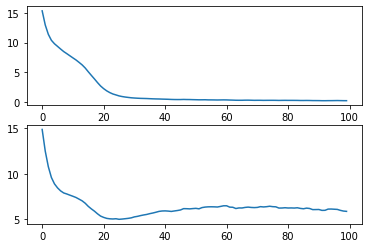

In [8]:
import torch
import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F

def dataProcess(dataframe,batchSize,labelsColumn,isTrain,oneHot):
    def categoryToLabel(dataframe):
      #with side inform: more features columns
      confeatureList=['cool', 'funny', 'useful']
    

      catfeatureList=["user_id",'business_id']
      from sklearn import preprocessing
      NewcatfeatureList=[]
      for i in catfeatureList:
        le = preprocessing.LabelEncoder()
        le.fit(dataframe[i])
        dataframe[i+"_code"]=le.transform(dataframe[i])
        NewcatfeatureList.append(i+"_code")
      return dataframe,NewcatfeatureList,confeatureList
    

    
    dataframe,catfeatureList,confeatureList=categoryToLabel(dataframe)
    catFeatures=catfeatureList
    conFeatures=confeatureList
    NumOfData=len(dataframe)
    
    NumofElementInBatch=int(NumOfData/batchSize)

    DataList=[]
    AllColumns=conFeatures
    
    ydataList=[]
    
    Alldata=[]
    AllMax=np.zeros(len(catFeatures)).tolist()

   
    for eachfeature in range(len(catFeatures)):
        Data=dataframe[catFeatures[eachfeature]]
        
        maxNum=np.max(Data)
        if maxNum>AllMax[eachfeature]:
            AllMax[eachfeature]=maxNum

        AllMax[eachfeature]=AllMax[eachfeature]+2
        print("EachFeature MAx",catFeatures[eachfeature],AllMax[eachfeature])
        
    for i in range(NumofElementInBatch):
        data_continuous=dataframe[i*batchSize:(i+1)*batchSize][AllColumns]
        data_category=dataframe[i*batchSize:(i+1)*batchSize][catFeatures]
        
       
        data_continuous=data_continuous.to_numpy(dtype=float)
        data_category=data_category.to_numpy(dtype=int)
        
        
        
        y=dataframe[i*batchSize:(i+1)*batchSize][labelsColumn].to_numpy(dtype=float)
        
        Alldata.append(((torch.tensor(data_continuous).float(),torch.tensor(data_category)),torch.tensor(y).squeeze(1)))
        
       
    return Alldata,AllMax,catFeatures,conFeatures

def mytrain(model, optimizer, dataset, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
  
    for i, (fields, target) in enumerate(dataset):
#         print('fields[0].size()',fields[0].size())
        X_Con = fields[0].to(device)
        X_Cat = fields[1].to(device)
        
        target = target.to(device)
       
        y = model((X_Con,X_Cat))
       
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
       
    return total_loss
def mytest(model, dataset, device):
    from sklearn import metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import mean_squared_error
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in dataset:
            X_Con = fields[0].to(device)
            X_Cat = fields[1].to(device)

            target = target.to(device)
            y = model((X_Con,X_Cat))
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return mean_squared_error(targets, predicts)
def split_train_test(dataset,ratio):
    print(len(dataset),"len(dataset)")
    a=[i for i in range(len(dataset))]
    trainSetIndex=np.random.choice(a,int(len(dataset)*ratio),replace=False)
    testSetIndex=list(set(a)-set(trainSetIndex))
    trainset=[]
    testset=[]
    for i in range(len(dataset)):
        if i in testSetIndex:
            testset.append(dataset[i])
        else:
            trainset.append(dataset[i])
    
    return trainset,testset
    
    

def combineGraph(dataframe):
    model = Word2Vec.load('./Node2Vec.model')
    
    vector = model.wv.get_vector(dataframe.iloc[0]['user_id'])
    vectorDim=vector.shape[0]
    NewColumnsName=dataframe.columns.tolist()+["Dim_"+str(i) for i in range(vectorDim)]
    NewDataFrame=pd.DataFrame([],columns=NewColumnsName)
    for i in range(len(dataframe)):
        if i%1000==3:
            print("continue..")
        user_id=dataframe.iloc[i]['user_id']
        vector=model[user_id]
        features=dataframe.iloc[i][:].tolist()+vector.tolist()
        
        rowdataFrame=pd.DataFrame([features],columns=NewColumnsName)
        NewDataFrame=pd.concat([NewDataFrame, rowdataFrame], ignore_index=True)
        
    return NewDataFrame
def NFMwithSideInformation(
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device):
    device = torch.device(device)
    
    dataframe=pd.read_csv("https://storage.googleapis.com/aldrichstorage/yelp/smaller/rates_filtered.csv")
    dataframe=combineGraph(dataframe)
  
    
    
    dataset,AllMax,catFetures,conFeatures=dataProcess(dataframe,23,["stars"],True,False)
    
    
  
    dataset,testSet=split_train_test(dataset,0.8)
    testdataset=testSet
    validdataset=testSet

    
    field_dims=AllMax 
   
    input_dims=len(confeatureList)

    model=NeuralFMModel(input_dims,field_dims , embed_dim=32, mlp_dims=(64,), dropouts=(0.2, 0.2)).to(device)
    
    criterion= torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    trainMSE=[]
    testMSE=[]
    for epoch_i in range(epoch):
        mytrain(model, optimizer, dataset, criterion, device)
        performance_train= mytest(model, dataset, device)
        performance_test= mytest(model, validdataset, device)
        print('epoch:', epoch_i,'train performance',performance_train, 'validation: performance:', performance_test)
        trainMSE.append(performance_train)
        testMSE.append(performance_test)
    performance= mytest(model, testdataset, device)
    print(f'test performance: {performance}')
    return trainMSE,testMSE

def NFM(
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device):
    device = torch.device(device)
   
    dataframe=pd.read_csv("https://storage.googleapis.com/aldrichstorage/yelp/smaller/rates_filtered.csv")
    
    print(dataframe.columns)
    
    
    dataset,AllMax,catFetures,conFeatures=dataProcess(dataframe,23,["stars"],True,False)
    
    
    dataset,testSet=split_train_test(dataset,0.8)
    testdataset=testSet
    validdataset=testSet

    
    
    field_dims=AllMax 
    print(field_dims)
    input_dims=len(conFeatures)

    model=NeuralFMModel(input_dims,field_dims , embed_dim=32, mlp_dims=(64,), dropouts=(0.2, 0.2)).to(device)
    
    criterion= torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
   
    
    trainMSE=[]
    testMSE=[]
    for epoch_i in range(epoch):
        mytrain(model, optimizer, dataset, criterion, device)
        performance_train= mytest(model, dataset, device)
        performance_test= mytest(model, validdataset, device)
        print('epoch:', epoch_i,'train performance',performance_train, 'validation: performance:', performance_test)
        trainMSE.append(performance_train)
        testMSE.append(performance_test)
    performance= mytest(model, testdataset, device)
    print(f'test performance: {performance}')
    return trainMSE,testMSE
if __name__ == '__main__':
    import argparse
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    # trainMSE,testMSE=NFMwithSideInformation(100,0.001,61,0.001,"cpu")
    trainMSE2,testMSE2=NFM(100,0.001,61,0.001,"cpu")
    
    plt.subplot(2,1,1)
    # plt.plot(trainMSE)
    plt.plot(trainMSE2)
    plt.subplot(2,1,2)
    # plt.plot(testMSE)
    plt.plot(testMSE2)
    plt.show()

NameError: ignored

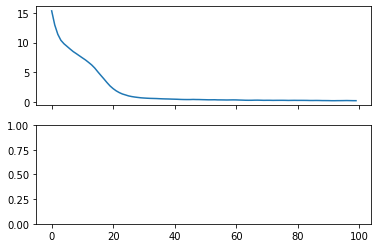

In [9]:

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
fig, (ax1,ax2)= plt.subplots(2, 1, sharex='col')

ax1.plot(trainMSE2,label="NFM ")
ax1.plot(trainMSE,label="NFM with side information")


ax2.plot(testMSE2,label="NFM ")
ax2.plot(testMSE,label="NFM with side information")


lines = []
labels = []

for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
ax1.set_title("Training MSE")
ax2.set_title("Testing MSE")

fig.legend(lines, labels,           
           loc = 'upper right',fontsize=8,ncol=1)
fig.savefig('NFM_Compare_Result.png')

